In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import shelve

BACKTEST = 3 # years, recommend at least 1~3 years
LOWER_BOUND = 0 #increase for diversification 
UPPER_BOUND = 0.4
NUM_OF_SIMULATIONS = 5000 #for monte carlo simulation
SEED = 1700000 #a principal of 1,300,000KRW
lambda_penalty = 0.5 #increase for robustness & diversificaiton, try 0.1 ~ 10

In [2]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'NVDA', 'AVGO', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
tickers = []

with shelve.open("ticker_cache") as cache:
    for ticker, name in cache.items():
        tickers.append(ticker)


In [3]:
#stock = yf.Ticker("379800.KS") #개별주 시장가 확인
stock = yf.Ticker("KRW=X") #환율
price = stock.info['regularMarketPrice']
print(stock.info['currency'] + " " + str(price))

KRW 1366.49


In [4]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

               007340.KS      271560.KS     005930.KS    005440.KS  \
Date                                                                 
2022-06-07  12936.446289   90455.148438  61245.089844  4231.879395   
2022-06-08  12936.446289   89113.656250  61058.078125  4317.118164   
2022-06-09  12858.632812   89209.484375  60964.574219  4342.188477   
2022-06-10  12177.767578   88251.265625  59655.515625  4287.034180   
2022-06-13  11671.981445   87388.875000  58065.953125  4126.583496   
...                  ...            ...           ...          ...   
2025-05-28  22100.000000  111200.000000  55900.000000  7280.000000   
2025-05-29  22300.000000  111600.000000  56100.000000  7380.000000   
2025-05-30  21950.000000  110400.000000  56200.000000  7460.000000   
2025-06-02  21700.000000  110800.000000  56800.000000  7390.000000   
2025-06-04  22300.000000  111700.000000  57800.000000  8100.000000   

               185750.KS     090435.KS      090430.KS     035900.KQ  \
Date              

In [5]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [6]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           007340.KS  271560.KS  005930.KS  005440.KS  185750.KS  090435.KS  \
007340.KS   0.205411   0.026373   0.032571   0.033147   0.047697   0.040948   
271560.KS   0.026373   0.080033   0.019487  -0.006850   0.013036   0.020515   
005930.KS   0.032571   0.019487   0.093843   0.032796   0.022950   0.012057   
005440.KS   0.033147  -0.006850   0.032796   0.134415   0.023274   0.022679   
185750.KS   0.047697   0.013036   0.022950   0.023274   0.062117   0.043870   
...              ...        ...        ...        ...        ...        ...   
005380.KS   0.046852   0.011336   0.055656   0.028110   0.030043   0.023881   
145020.KQ   0.050300   0.011318   0.023609   0.037808   0.035641   0.072204   
009970.KS   0.055065   0.024884   0.039750   0.035522   0.030784   0.035705   
259960.KS   0.045857  -0.025227   0.009919   0.027717   0.032107   0.042105   
005290.KQ   0.036809   0.009944   0.082549   0.044558   0.018317  -0.001749   

           090430.KS  035900.KQ  086280.KS  009540.

In [7]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [8]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [9]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [10]:
from fredapi import Fred
#https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '34e4735c415e19669e7094dbd83af34f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_21773/3437368303.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [11]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + (lambda_penalty * np.sum(weights**2))

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#say you wanna fix AVGO's weight to be exactly 0.25. if you want it to be at least 0.25, change 'eq' to 'ineq'
# constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
#               {'type': 'eq', 'fun': lambda weights: weights[tickers.index('379800.KS')] - 0.75}]
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [12]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [13]:
optimal_weights = optimized_results.x #.x gets the results

In [14]:
# print("Optimal Weights:")
# for ticker, weight in zip(tickers, optimal_weights):
#     print(f"{ticker}: {weight:.4f}")

# optimal_portfolio_return = expected_return(optimal_weights, log_returns)
# optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
# optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
# print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

In [15]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimal_weights)

# plt.xlabel('Assets')
# plt.ylabel('Optimal Weights')
# plt.title('Optimal Portfolio Weights')

# plt.show()

In [16]:
# Initialize the components, to run a Monte Carlo Simulation.
number_of_symbols = len(tickers)
# We will run 5000 iterations.
num_of_portfolios = NUM_OF_SIMULATIONS

float_formatter = "{:.2f}".format

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_returns.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio

simulations_data = [ret_arr, vol_arr, sharpe_arr, np.round(all_weights, 4)]
# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

data = {
    'Portfolio Weights': [
        np.random.rand(10).tolist() for _ in range(5000)
    ]
}
df = pd.DataFrame(data)

# Set Pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', None)  # To prevent truncation of column values

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
MAX_LINE = 100
# print('')
# print('='*MAX_LINE)
# print('SIMULATIONS RESULT:')
# print('-'*MAX_LINE)
# with np.printoptions(threshold=sys.maxsize):
#     print(simulations_df)
# print('-'*MAX_LINE)

In [17]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
monte_carlo_max_sharpe_weights = max_sharpe_ratio.loc['Portfolio Weights']
# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
monte_carlo_min_vol_weights = min_volatility.loc['Portfolio Weights']

print('')
print('='*MAX_LINE)
print('MAX SHARPE RATIO:')
print('-'*MAX_LINE)
print(max_sharpe_ratio)
print('-'*MAX_LINE)

print('')
print('='*MAX_LINE)
print('MIN VOLATILITY:')
print('-'*MAX_LINE)
print(min_volatility)
print('-'*MAX_LINE)


MAX SHARPE RATIO:
----------------------------------------------------------------------------------------------------
Returns                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            0.770746
Volatility                                                                                                                                                                                                                                                                          

Re-reun SLSQP Optimization with weights from Monte Carlo simulation as initial guess to land a global Sharpe Maximum and enhance results

In [18]:
optimized_results_max_sharpe = minimize(neg_sharpe_ratio, monte_carlo_max_sharpe_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results_min_vol = minimize(neg_sharpe_ratio, monte_carlo_min_vol_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [19]:
optimal_weights = optimized_results_max_sharpe.x
threshold = 10e-4

# print(optimal_weights)
# optimal_weights = optimized_results_min_vol.x

print("Optimal Weights (최적화 가중치):")
print("원금: " + f"{SEED:,}"+ "원. 백테스팅 기간: " + F"{BACKTEST}" + "년")
for ticker, weight in zip(tickers, optimal_weights):
    if weight >= threshold:
        num = round(SEED * weight)
        with shelve.open("ticker_cache") as cache:
            print(f"{ticker}({cache[ticker]}): {weight:.4f}" + ", 투자금액: " +  str(f"{num:,}") + "원")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights (최적화 가중치):
원금: 1,700,000원. 백테스팅 기간: 3년
271560.KS(ORION Corp.): 0.0642, 투자금액: 109,088원
005440.KS(Hyundai G.F. Holdings Co., Ltd.): 0.1534, 투자금액: 260,813원
001800.KS(ORION Holdings Corp.): 0.1066, 투자금액: 181,293원
012450.KS(Hanwha Aerospace Co., Ltd.): 0.0090, 투자금액: 15,333원
047810.KS(Korea Aerospace Industries, Ltd.): 0.0011, 투자금액: 1,903원
064350.KS(Hyundai Rotem Company): 0.0866, 투자금액: 147,211원
022100.KS(Posco Dx Company Ltd.): 0.0128, 투자금액: 21,758원
111770.KS(Youngone Corporation): 0.0477, 투자금액: 81,099원
089860.KS(LOTTE rental co.,ltd.): 0.0882, 투자금액: 149,911원
214450.KQ(PharmaResearch Co., Ltd.): 0.1216, 투자금액: 206,702원
000720.KS(Hyundai Engineering & Construction Co.,Ltd.): 0.1878, 투자금액: 319,295원
009970.KS(Youngone Holdings Co., Ltd.): 0.1209, 투자금액: 205,593원
Expected Annual Return: 1.7296
Expected Volatility: 0.2274
Sharpe Ratio: 7.4113


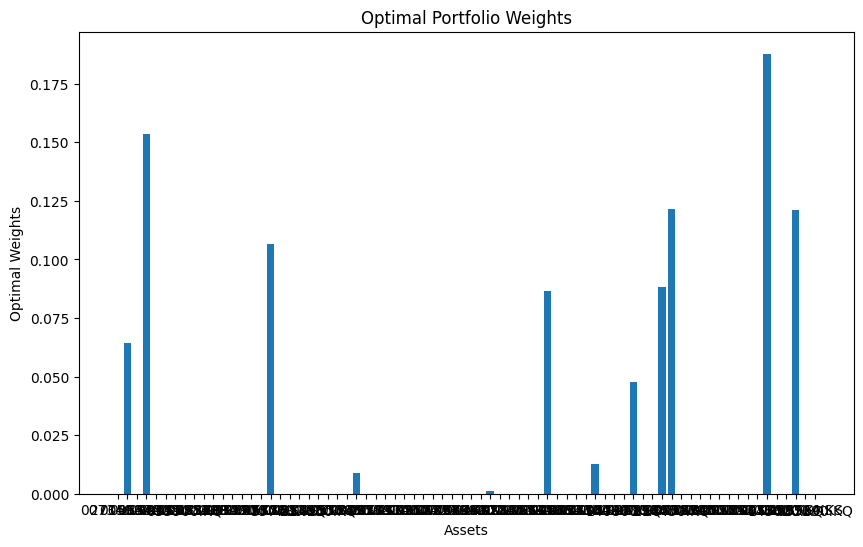

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()